In [ ]:
'''Test if marker recognization is sufficient'''
from pvc_tensile_experiment.Functions import *

# variable inputs
folderName = 'Data/PVC P8 Test_0'

# set pixel area limits for the search region and the
# the lower color bound
searchRegion = [60, 4500]
lowerColorLims = [80, 150, 130] # min [80, 80, 100], max [80, 150, 125]

# define the opening kernel and use
kernelSize = 3
useKernel = False

# check the particle areas are increasing and verify if there are abnormal changes to position
MaskCheck(folderplastiRatio, searchRegion, lowerColorLims, useKernel, kernelSize)


In [ ]:
'''Run the particle tracking, compute strain, and couple stress and strain'''
from pvc_tensile_experiment.Functions import *

# find the tracked particles
tracked = ParticleIdentify(folderplastiRatio, searchRegion, lowerColorLims, useKernel, kernelSize)

# process the data and compile, getting strain and stress calculations 
axDist, axStrain, transDist, transStrain, stress  = StrainFunction(folderplastiRatio, tracked)


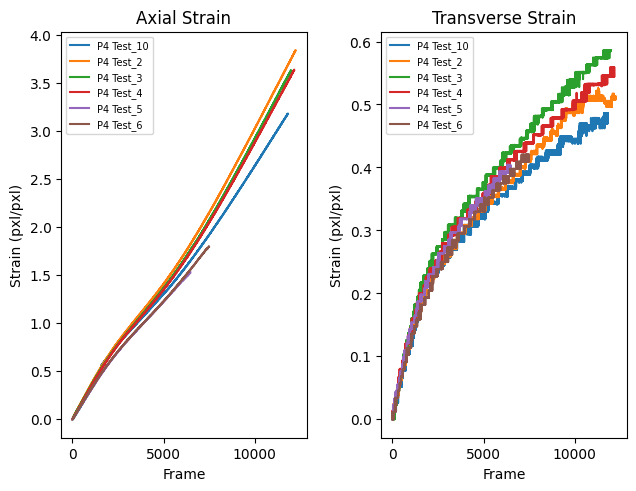

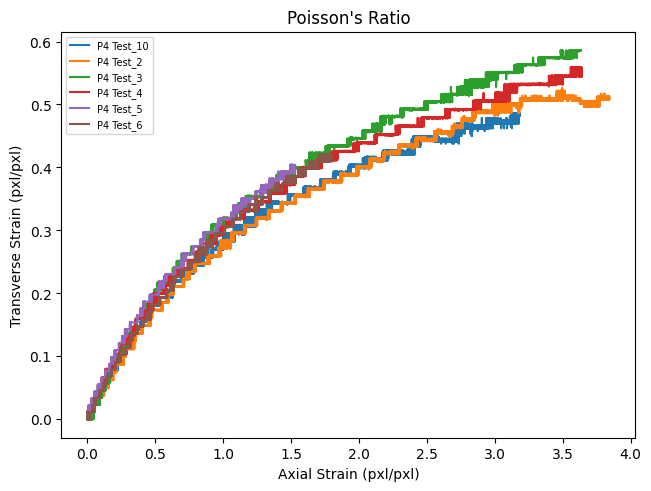

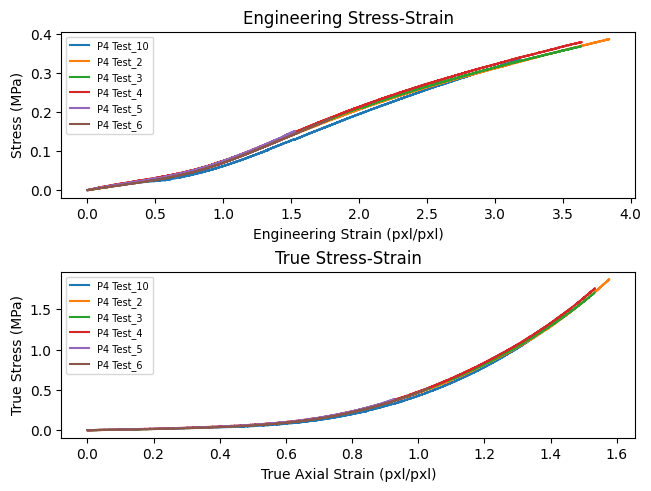

In [2]:
"""Overlay the individual processed data set on a plot"""
from pvc_tensile_experiment.Functions import DataReader
import os; import matplotlib.pyplot as plt
import numpy as np

# the desired plasticizer ratio 
plastiRatio = 'P4'

# list the processed file names
fileNames = [i for i in os.listdir('Processed data/Modeling Data') if i.find(f'{plastiRatio}') != -1]

# preallocate the suplots
fig, axs = plt.subplots(1,2, layout = "constrained")
fig, axs1 = plt.subplots(1,1, layout = "constrained")
fig, axs2 = plt.subplots(2,1, layout = "constrained")

for name in fileNames:
    # read the processed data files 
    axDist, axStrain, transDist, transStrain, stress = DataReader(name)
    
    # find true strain and stress from engineering strain
    stretchRatio = 1 + axStrain
    axStrainTrue = np.log(stretchRatio) 
    stressTrue = stress*stretchRatio

    # remove csv from the name
    name = name.removesuffix('.csv').removeprefix('PVC ')

    # plot the engineering axial and transverse strain per frame
    axs[0].plot(axStrain, label = f'{name}')
    axs[1].plot(transStrain, label = f'{name}')
    axs[0].set_title('Axial Strain')
    axs[1].set_title('Transverse Strain')
    axs[0].set_xlabel('Frame')
    axs[1].set_xlabel('Frame')
    axs[0].set_ylabel('Strain (pxl/pxl)')
    axs[1].set_ylabel('Strain (pxl/pxl)')
    axs[0].legend(fontsize = 7)
    axs[1].legend(fontsize = 7)

    # plot poissons ratio 
    axs1.plot(axStrain, transStrain, label = f'{name}')
    axs1.set_title("Poisson's Ratio")
    axs1.set_xlabel('Axial Strain (pxl/pxl)')
    axs1.set_ylabel('Transverse Strain (pxl/pxl)')
    axs1.legend(fontsize = 7)

    # plot engineering stress-strain and true stress-strain
    axs2[0].plot(axStrain, stress, label = f'{name}')   
    axs2[1].plot(axStrainTrue, stressTrue, label = f'{name}')
    axs2[0].set_xlabel('Engineering Strain (pxl/pxl)')
    axs2[1].set_xlabel('True Axial Strain (pxl/pxl)')
    axs2[0].set_ylabel('Stress (MPa)')
    axs2[1].set_ylabel('True Stress (MPa)')
    axs2[0].set_title('Engineering Stress-Strain')
    axs2[1].set_title('True Stress-Strain')
    axs2[0].legend(fontsize = 7)
    axs2[1].legend(fontsize = 7)

plt.show()


In [ ]:
"""Overlay the all used datasets on a plot"""
from pvc_tensile_experiment.Functions import DataComplile
import matplotlib.pyplot as plt; import numpy as np

# preallocate the suplots
fig, axs1 = plt.subplots(1,1, layout = "constrained")
fig, axs2 = plt.subplots(2,1, layout = "constrained")


# the desired plasticizer ratio 
for plastiRatio in ['P2', 'P4', 'P6', 'P8']:

    # read the processed data files 
    _, axStrain, _, transStrain, stress = DataComplile(plastiRatio)

    # find true strain and stress from engineering strain
    stretchRatio = 1 + axStrain
    axStrainTrue = np.log(stretchRatio) 
    stressTrue = stress*stretchRatio
    
    # define marker size
    size = 1

    # plot poissons ratio 
    axs1.scatter(axStrain, transStrain, label = f'{plastiRatio}', s = size)
    axs1.set_title("Poisson's Ratio")
    axs1.set_xlabel('Axial Strain (pxl/pxl)')
    axs1.set_ylabel('Transverse Strain (pxl/pxl)')
    axs1.legend(fontsize = 7)

    # plot engineering stress-strain and true stress-strain
    axs2[0].scatter(axStrain, stress, label = f'{plastiRatio}', s = size)   
    axs2[1].scatter(axStrainTrue, stressTrue, label = f'{plastiRatio}', s = size)
    axs2[0].set_xlabel('Engineering Strain (pxl/pxl)')
    axs2[1].set_xlabel('True Axial Strain (pxl/pxl)')
    axs2[0].set_ylabel('Stress (MPa)')
    axs2[1].set_ylabel('True Stress (MPa)')
    axs2[0].set_title('Engineering Stress-Strain')
    axs2[1].set_title('True Stress-Strain')
    axs2[0].legend(fontsize = 7)
    axs2[1].legend(fontsize = 7)

    
plt.show()

In [ ]:
"""Combined elastic modulus and poissons ratio"""
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt; import numpy as np
from pvc_tensile_experiment.Functions import *

def LinearFit(x, a, b):
    return a*x + b

# define the plasticizer ration we want
plastiRatio = 'P8'

# compile all the data  
axDist, axStrain, transDist, transStrain, stress = DataComplile(plastiRatio)

# define the elastic region
elasRegion = [list(axStrain).index(i) for i in axStrain if i < 0.2 and i > 0.05]
elasAxStrain = axStrain[elasRegion]
elasTransStrain = transStrain[elasRegion]
elasStress = stress[elasRegion]

# curve fit the elastic region. find the 
xfit = np.linspace(elasAxStrain[0], elasAxStrain[-1])
poptE, pcovE = curve_fit(LinearFit, elasAxStrain, elasStress)
poptP, pcovP = curve_fit(LinearFit, elasAxStrain, elasTransStrain)


# plot engineering stress vs strain
plt.figure(0)
plt.scatter(elasAxStrain, elasStress)
plt.plot(xfit, LinearFit(xfit, poptE[0], poptE[1]), 'r')
plt.xlabel('Axial Strain (pxl/pxl)')
plt.ylabel('Stress (MPa)')
plt.title('Elastic Modulus')
plt.show()

# plot poissons ratio
plt.figure(1)
plt.scatter(elasAxStrain, elasTransStrain)
plt.plot(xfit, LinearFit(xfit, poptP[0], poptP[1]), 'r')
plt.xlabel('Axial Strain (pxl/pxl)')
plt.ylabel('Transverse Strain (pxl/pxl)')
plt.title('Poissons Ratio')
plt.show()

In [ ]:
"""Curve fitting"""
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt


# find true strain and stress from engineering strain
stretchRatio = 1 + axStrain
axStrainTrue = np.log(stretchRatio) 
stressTrue = stress*stretchRatio

# Sample uniaxial stress and strain data (replace these arrays with your actual data)
true_strain = axStrainTrue # True strain values
true_stress = stressTrue     # True stress values

# Define the Arruda-Boyce model function for uniaxial stress
def arruda_boyce_model(strain, mu, N):
    # Calculate the stretch ratio, lambda
    lambda_ = 1 + strain
    I1_bar = lambda_**2 + 2 / lambda_

    # Arruda-Boyce uniaxial stress-strain relationship
    return (mu / lambda_) * (lambda_**2 - 1 / lambda_) * (
        1 + (3 / 5) * ((I1_bar - 3) / N) +
        (99 / 175) * ((I1_bar - 3) / N)**2 +
        (513 / 875) * ((I1_bar - 3) / N)**3
    )

# Perform the curve fitting
popt, pcov = curve_fit(arruda_boyce_model, true_strain, stress, p0=[1.0, 5.0])

# Extract the fitted parameters
mu_fitted, N_fitted = popt
print(f"Fitted Arruda-Boyce parameters: mu = {mu_fitted}, N = {N_fitted}")

# Plotting the data and the fitted curve
strain_fit = np.linspace(min(true_strain), max(true_strain), 100)
stress_fit = arruda_boyce_model(strain_fit, mu_fitted, N_fitted)

plt.figure(figsize=(8, 5))
plt.plot(true_strain, stress, 'o', label='Experimental data')
plt.plot(strain_fit, stress_fit, '-', label=f'Arruda-Boyce fit ($\mu$ = {mu_fitted:.3f}, N = {N_fitted:.3f})')
plt.xlabel("True Strain")
plt.ylabel("True Stress")
plt.legend()
plt.title("Arruda-Boyce Hyperelastic Model Fit")
plt.show()

